#  Capstone Project: The Battle of the Neighborhoods

##  Introduction

My friends living in Cologne, Germany wish to relocate for professional reasons to Berlin, Germany. They reached out to me for recommendations on the Berlin suburbs. Rental prices are not their priority. They mentioned metrics like:

* number of shops
* number of restaurants
* number of cafes
* number of services (banks, ATMs, offices, etc)

They know such a decision is very subjective but since I have also lived in Cologne and I know the Cologne suburbs quite a bit, they asked me if I could make a mapping of Berlin-to-Colone suburbs. That way, since they are familiar with the Cologne suburbs, they can get a first impression idea of the Berlin suburbs and reach easier a decision more tailored to their needs.

##  Data needed for this project

In order to tackle such a problem, I collected the following data:

1. Official names of the [Berlin](https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin#Localities) and [Cologne](https://de.wikipedia.org/wiki/Liste_der_Stadtbezirke_und_Stadtteile_K%C3%B6lns) suburbs were web-scraped. Representative nodes of the suburbs were queried from the **Open Street Maps API**. Data were corrected to reflect the officially recognized suburbs and their names. At the end of this data extraction and transformation, I had all officially recognized suburbs of Berlin and Cologne represented as nodes in WGS (latitude/longitute) coordinates. 

2. The **Foursquare API** was queried around each representative suburb node using a radius that was determined separately for Berlin and Cologne. I wanted to capture enough of each suburb *character* allowing for query overlaps from neighboring suburbs in order to blend the suburb boundaries. This is because the reality on the ground is not influenced in any way by the administrative boundaries. A neighborhood can evolve across suburb boundaries and maintain its character. In such case, if the majority of the neighborhood lies only on one side of the boundary the similarity with the neighboring suburb will be missed if we do not allow for query blendings. 

3. For the coordinate system transformation (CRS) from the World Geodesic System (WGS) latitude/longitude to Universal Transverse Mercador (UTM) cartesian I used [EPSG:5243](https://epsg.io/5243) which is appropriate for Germany.

## Data Collection

### preliminary loading of python libraries and definition of helper functions

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import requests
from bs4 import BeautifulSoup

plt.rcParams.update({
    'figure.figsize': (20,10),
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 22,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 1.1,
    'lines.linewidth': 1.5,
    'lines.markersize': 4,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'xtick.major.size': 0,
    'xtick.minor.size': 0,
    'ytick.major.size': 0,
    'ytick.minor.size': 0,
    'grid.linewidth': 0,
    'legend.frameon': False,
    })

import json
import folium
from OSMPythonTools.overpass import Overpass, overpassQueryBuilder
from OSMPythonTools.nominatim import Nominatim

###  collecting the suburbs

In [3]:
#  geolocalize Berlin and Cologne, the areaId is what we need for all OSM queries
nominatim = Nominatim()
Berlin= nominatim.query('Berlin, Germany')
Cologne = nominatim.query('Cologne, Germany')

#  latitudes and longitudes of the cities
Berlin_lat, Berlin_lon = float(Berlin.toJSON()[0]['lat']), float(Berlin.toJSON()[0]['lon'])
Cologne_lat, Cologne_lon = float(Cologne.toJSON()[0]['lat']), float(Cologne.toJSON()[0]['lon'])

#### Official list of Cologne suburbs

In [4]:
#  web-scrape the official Wikipedia table
html_data = requests.get('https://de.wikipedia.org/wiki/Liste_der_Stadtbezirke_und_Stadtteile_K%C3%B6lns')
soup = BeautifulSoup(html_data.text, 'html.parser')

#  identify the table of interest
table = [table for table in soup.find_all('table') if 'Liste der 9 Stadtbezirke' in table.caption.text][0]

Cologne_suburbs = pd.DataFrame(columns=['suburb', 'population', 'area', 'density'])
for row in table.find('tbody').find_all('tr'):
    cols = row.find_all('td')
    try:
        _, suburb, population, area, density = map(lambda x: x.text.strip(), cols)
        Cologne_suburbs = Cologne_suburbs.append({'suburb': suburb, 'population': population, 'area': area, 
                                'density': density}, ignore_index=True)
    except:
        continue    #  header/footer entries

#  remove boroughs (Stadtbezirke) and keep suburbs only
Cologne_suburbs = Cologne_suburbs[ ~Cologne_suburbs.suburb.str.contains('Stadtbezirk') ].reset_index(drop=True)

#  fix: Marienburg (Köln) -> Marienburg
Cologne_suburbs.loc[ Cologne_suburbs.suburb.str.contains('\('), 'suburb'] = 'Marienburg'

#  show
Cologne_suburbs

,suburb,population,area,density
0,Altstadt-Süd,27.071,"2,36",11.469
1,Neustadt-Süd,37.719,"3,50",13.343
2,Altstadt-Nord,17.960,"2,46",7.301
3,Neustadt-Nord,28.720,"2,83",8.213
4,Deutz,15.563,"5,24",2.968
...,...,...,...,...
81,Dellbrück,21.430,"9,95",2.154
82,Höhenhaus,15.128,"5,08",2.980
83,Dünnwald,11.779,"10,85",1.086
84,Stammheim,7.473,"3,75",1.995


#### Official list of Berlin suburbs

In [5]:
#  web-scrape the official Wikipedia table
html_data = requests.get('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin#Localities')
soup = BeautifulSoup(html_data.text, 'html.parser')
Berlin_suburbs = pd.DataFrame(columns=['suburb', 'population', 'area', 'density'])

#  Here unfortunately, each burough is listed as a separate table. We need to iterate over all tables starting
#  from the third in the page
for table in soup.find_all('table')[2:]:  #  suburbs start from the third table  
    for row in table.find('tbody').find_all('tr'):
        cols = row.find_all('td')
        if len(cols)==5:  #  this is the first row which contains also a map image, let's remove it
            cols = cols[:-1]  
        try:
            suburb, area, population, density = map(lambda x: x.text.strip(), cols)
            Berlin_suburbs = Berlin_suburbs.append({'suburb': suburb, 'population': population, 'area': area, 
                                    'density': density}, ignore_index=True)
        except:
            continue    #  header/footer entries

#  remove suburb numbers
Berlin_suburbs['suburb'] = Berlin_suburbs.suburb.str.extract(r'\([0-9]+\)\s?(.*)$')
Berlin_suburbs

,suburb,population,area,density
0,Mitte,"79,582",10.70,"7,445"
1,Moabit,"69,425",7.72,"8,993"
2,Hansaviertel,"5,889",0.53,"11,111"
3,Tiergarten,"12,486",5.17,"2,415"
4,Wedding,"76,363",9.23,"8,273"
...,...,...,...,...
91,Waidmannslust,"10,022",2.30,"4,357"
92,Lübars,"4,915",5.00,983
93,Wittenau,"22,696",5.87,"3,866"
94,Märkisches Viertel,"35,206",3.20,"11,002"


#### Geolocalizing Cologne suburbs

In [6]:
#  query OSM for administrative area level 10 relations and return their representative center
query = Overpass().query(f'area({Cologne.areaId()});(rel[admin_level=10](area););out center;').toJSON()['elements']

#  populate the suburbs
co_suburbs = pd.DataFrame(columns=['suburb', 'lat', 'lon'])
for row in query:
    co_suburbs = co_suburbs.append({'suburb': row['tags']['name'], 'lat': row['center']['lat'], 
                                    'lon': row['center']['lon']}, ignore_index=True)

#  Weirdly enough according to the official suburb names we need to fix:
#
#      Neustadt/Nord -> Neustadt-Nord
#      Neustadt/Süd -> Neustadt-Süd
#
#  although other official suburb names use / for separations...
co_suburbs.loc[ co_suburbs.suburb.str.contains('Neustadt'), 'suburb'] = co_suburbs[ 
    co_suburbs.suburb.str.contains('Neustadt') ].suburb.str.replace('/', '-')

#  check that we have identified all official suburbs correctly and nothing more
assert( co_suburbs.suburb.isin(Cologne_suburbs.suburb).sum() == Cologne_suburbs.shape[0] 
       and co_suburbs.shape[0] == Cologne_suburbs.shape[0] )

co_suburbs

,suburb,lat,lon
0,Altstadt-Nord,50.942273,6.954198
1,Altstadt-Süd,50.929168,6.954555
2,Bayenthal,50.910572,6.970274
3,Bickendorf,50.960456,6.894356
4,Bilderstöckchen,50.972000,6.925608
...,...,...,...
81,Widdersdorf,50.966247,6.843913
82,Worringen,51.063690,6.858801
83,Zollstock,50.904541,6.937723
84,Zündorf,50.863853,7.045898


#### Geolocalizing Berlin suburbs

In [7]:
#  query OSM for administrative area level 10 relations and return their representative center
query = Overpass().query(f'area({Berlin.areaId()});(rel[admin_level=10](area););out center;').toJSON()['elements']

#  populate the suburbs
be_suburbs = pd.DataFrame(columns=['suburb', 'lat', 'lon'])
for row in query:
    be_suburbs = be_suburbs.append({'suburb': row['tags']['name'], 'lat': row['center']['lat'], 
                                    'lon': row['center']['lon']}, ignore_index=True)

#  fix: remove Schlachtensee from the OSM list, it is not officially recognized as a Berlin suburb
be_suburbs = be_suburbs[ ~be_suburbs.suburb.isin(['Schlachtensee']) ]

#  check that we have identified all official suburbs correctly and nothing more
assert( be_suburbs.suburb.isin(Berlin_suburbs.suburb).sum() == Berlin_suburbs.shape[0] 
       and be_suburbs.shape[0] == Berlin_suburbs.shape[0] )

be_suburbs

,suburb,lat,lon
0,Reinickendorf,52.574120,13.344828
1,Frohnau,52.642756,13.286213
2,Charlottenburg-Nord,52.539513,13.299556
3,Mitte,52.522219,13.397631
4,Hansaviertel,52.518227,13.342270
...,...,...,...
91,Falkenberg,52.576872,13.548868
92,Friedrichsfelde,52.502790,13.517263
93,Neu-Hohenschönhausen,52.567192,13.512745
94,Oberschöneweide,52.467997,13.530395


### Suburb visualization

In [8]:
#  Berlin suburbs
be_map = folium.Map(location=[Berlin_lat, Berlin_lon], zoom_start=11)
for lat, lng, label in zip(be_suburbs.lat, be_suburbs.lon, be_suburbs.suburb):
    pop_label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=pop_label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(be_map)
be_map.save('images/Berlin_suburbs.html')
be_map

In [9]:
#  Cologne suburbs
co_map = folium.Map(location=[Cologne_lat, Cologne_lon], zoom_start=11)
for lat, lng, label in zip(co_suburbs.lat, co_suburbs.lon, co_suburbs.suburb):
    pop_label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=pop_label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(co_map)
co_map.save('images/Cologne_suburbs.html')
co_map

## Deciding on the query radii

I needed to decide on the **Foursquare** query radius (in meters) around the representative nodes of the suburbs for each city separately. For that, I converted the coordinates from WGS to UTM and computed the distance of each node to its nearest. I followed the [pyproj example](https://pyproj4.github.io/pyproj/stable/examples.html#step-2-create-transformer-to-convert-from-crs-to-crs) to do that.

In [10]:
#  define WGS-to-UTM and UTM-to-WGS transformers
from pyproj import Transformer
wgs2utm = Transformer.from_crs('EPSG:4326', 'EPSG:5243')
utm2wgs = Transformer.from_crs('EPSG:5243', 'EPSG:4326')

In [11]:
#  add x,y coordinates to the representative points of suburbs
def add_xy(df):
    x, y = wgs2utm.transform(df.lat, df.lon)
    return pd.Series([x[0], y[0]], index=['x', 'y'])

#  Berlin
df = be_suburbs.set_index('suburb')
be_suburbs = pd.concat([df, df.groupby(level=0).apply(add_xy)], axis=1).reset_index()

#  Cologne
df = co_suburbs.set_index('suburb')
co_suburbs = pd.concat([df, df.groupby(level=0).apply(add_xy)], axis=1).reset_index()

In [12]:
#  Compute all pairwise distances and pick the shortest
def find_closest(df):
    df1 = df.loc[:,['x', 'y']]
    
    #  outer join of x,y points with themselves creates all pairwise combinations, however,
    #  we need to make sure to remove self-distances.
    df1['key'] = 1
    pairs = pd.merge(df1, df1, how='outer', on='key', suffixes=('_1', '_2')).drop('key',
        axis=1).query('x_1!=x_2 & y_1!=y_2')
    assert( pairs.shape[0] == df1.shape[0]**2 - df1.shape[0] )
    
    #  compute Euclidean distance between each pair
    pairs['distance'] = np.sqrt(np.power(pairs.x_2 - pairs.x_1, 2) + np.power(pairs.y_2 - pairs.y_1, 2))
    
    #  find the first shortest
    pairs = pairs.groupby(['x_1', 'y_1'], group_keys=False).apply(lambda df: 
        df.query('distance == distance.min()')).reset_index(drop=True)
    
    return pairs


#  convert pair coordinates from UTM to WGS 
def add_latlon_for_pairs(df):
    lat1, lon1 = utm2wgs.transform(df['x_1'], df['y_1'])
    lat2, lon2 = utm2wgs.transform(df['x_2'], df['y_2'])
    return pd.Series([lat1, lon1, lat2, lon2], index=['lat_1', 'lon_1', 'lat_2', 'lon_2'])

In [13]:
#  Berlin
pairs = find_closest(be_suburbs)
be_suburbs_pairs = pd.concat([pairs, pairs.apply(add_latlon_for_pairs, axis=1)], axis=1)

#  Cologne
pairs = find_closest(co_suburbs)
co_suburbs_pairs = pd.concat([pairs, pairs.apply(add_latlon_for_pairs, axis=1)], axis=1)

####  Visually inspecting nearest neighbors

In [14]:
#  [Berlin] 
#  draw lines between closest points
points = [ (point[0], point[1]) for point in zip(be_suburbs_pairs[['lat_1', 'lon_1']].values, 
                                                 be_suburbs_pairs[['lat_2', 'lon_2']].values) ]
be_map = folium.Map(location=[Berlin_lat, Berlin_lon], zoom_start=10)
for lat, lng, label in zip(be_suburbs.lat, be_suburbs.lon, be_suburbs.suburb):
    pop_label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=pop_label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(be_map)
for i in range(be_suburbs_pairs.shape[0]):
    folium.PolyLine(points, color='red').add_to(be_map)
be_map.save('images/Berlin_nearest-neighbors.html')
be_map 

In [15]:
#  [Cologne] 
#  draw lines between closest points
points = [ (point[0], point[1]) for point in zip(co_suburbs_pairs[['lat_1', 'lon_1']].values, 
                                                 co_suburbs_pairs[['lat_2', 'lon_2']].values) ]
co_map = folium.Map(location=[Cologne_lat, Cologne_lon], zoom_start=11)
for lat, lng, label in zip(co_suburbs.lat, co_suburbs.lon, co_suburbs.suburb):
    pop_label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=pop_label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(co_map)
for i in range(co_suburbs_pairs.shape[0]):
    folium.PolyLine(points, color='red').add_to(co_map)
co_map.save('images/Cologne_nearest-neighbors.html')
co_map

We see that the method worked very well identifying the nearest-neighbor of each suburb and computing the distance between them. I show below the distributions of these nearest-neighbor distances.

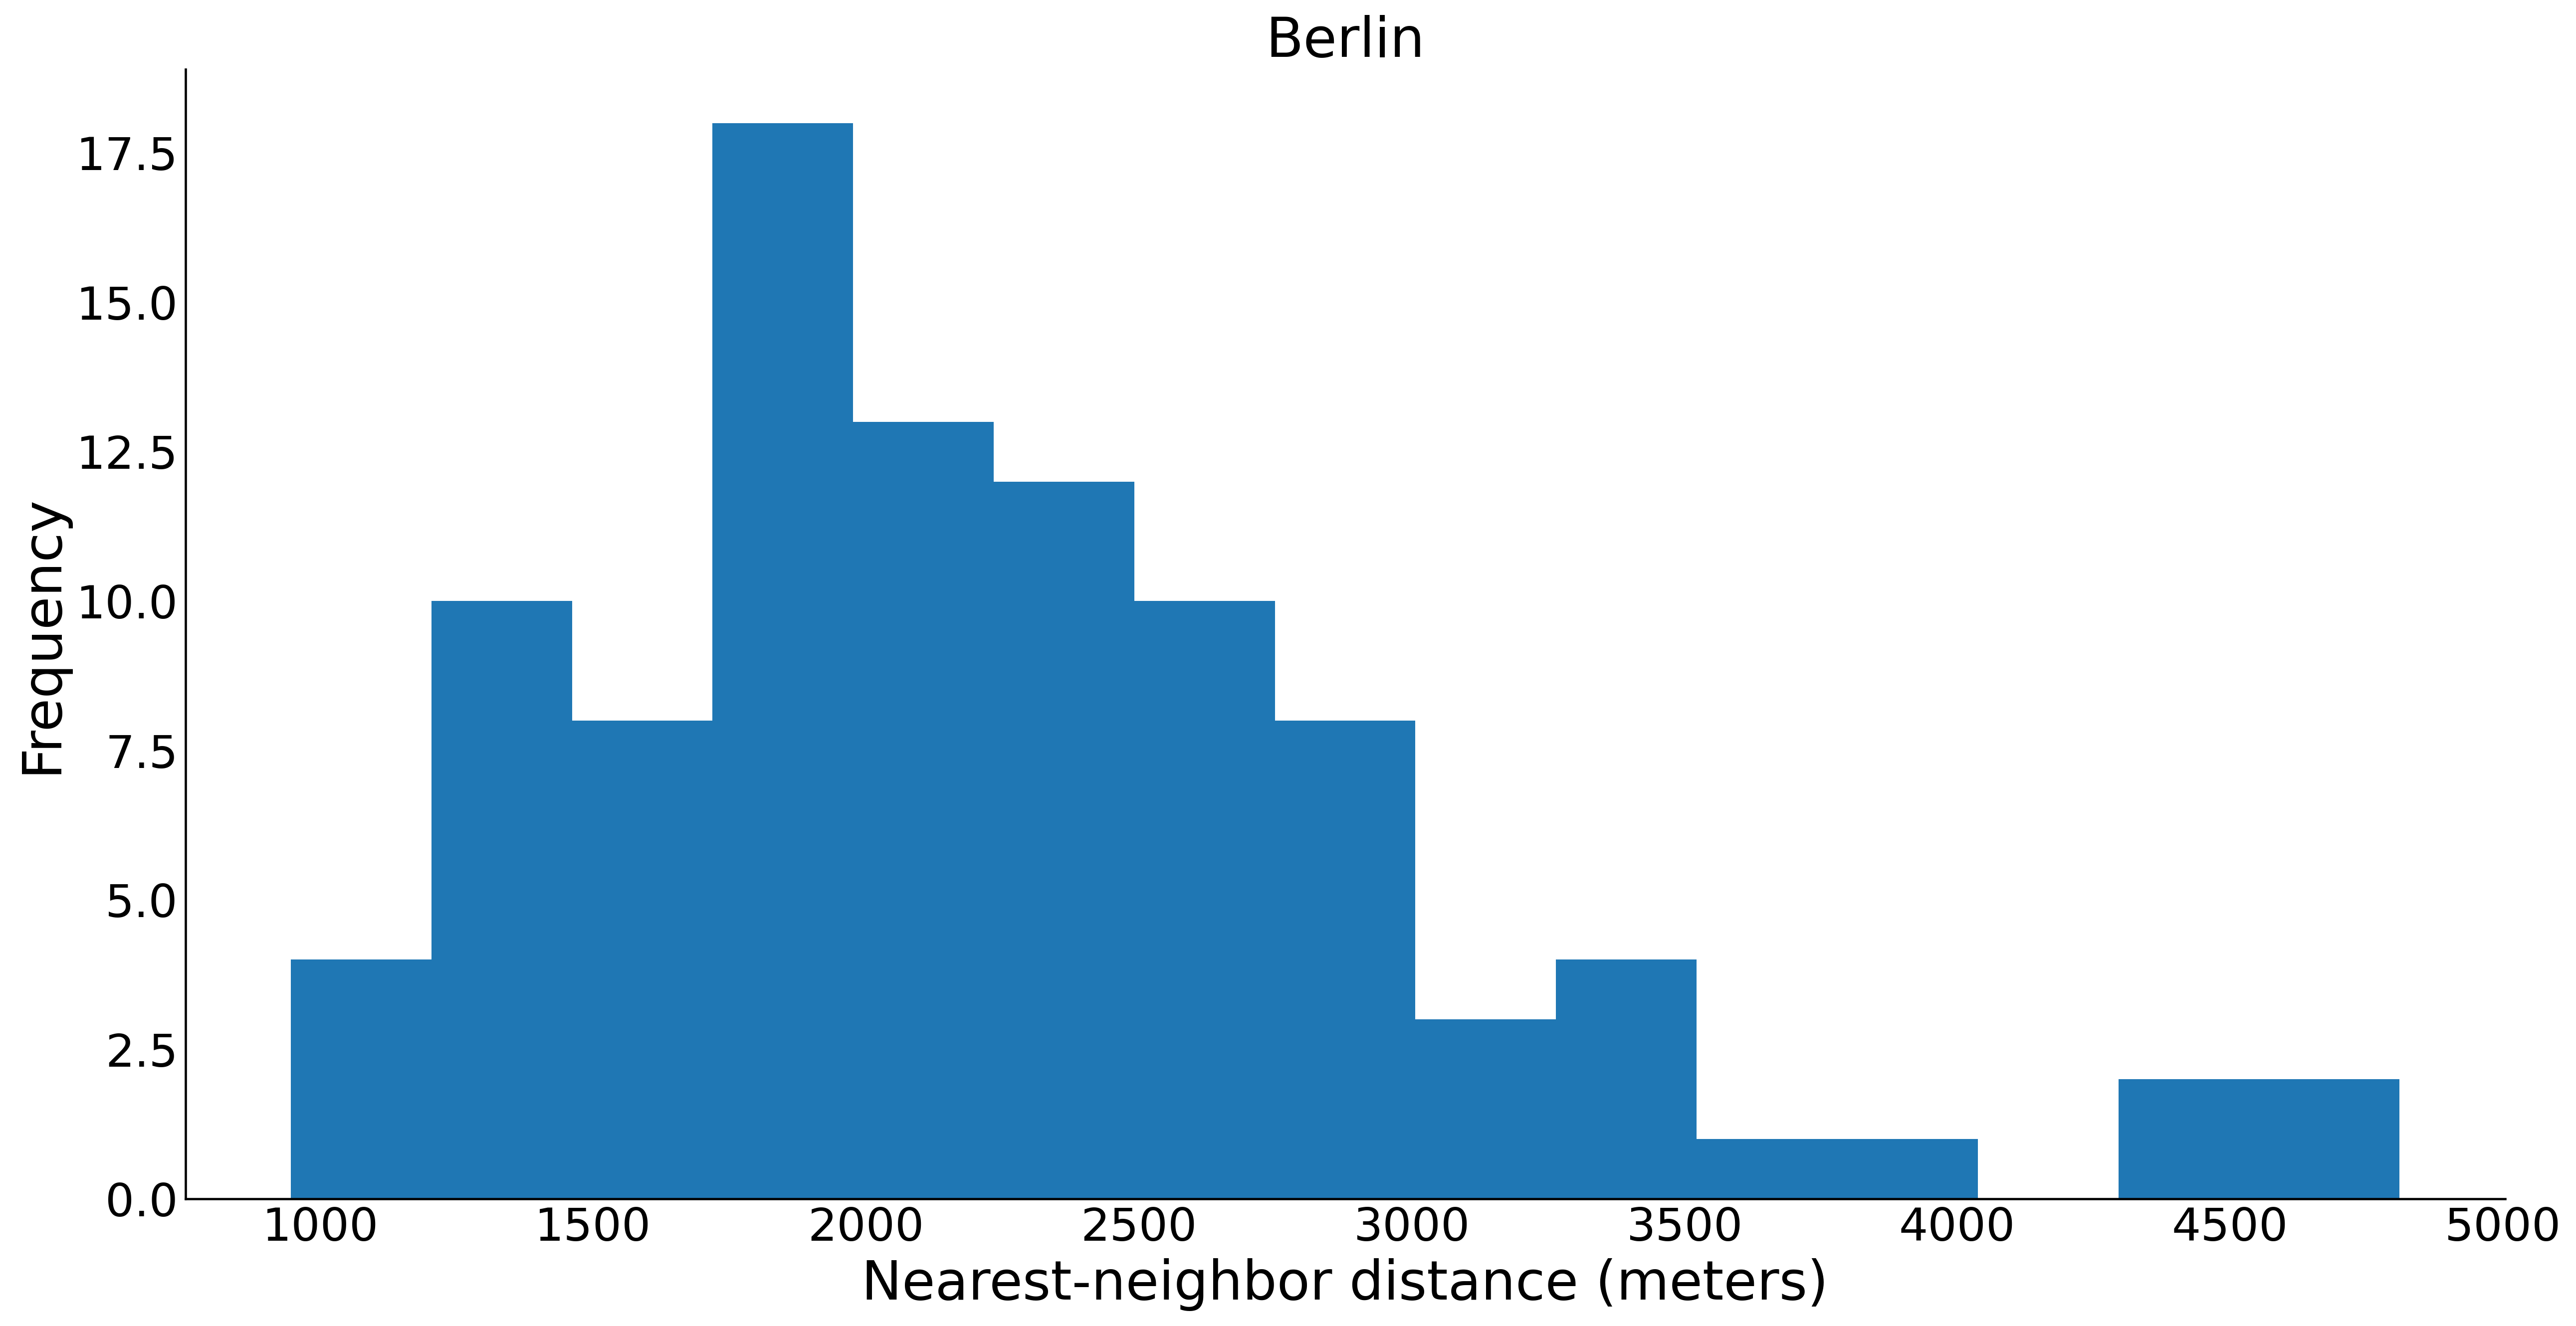

In [16]:
#  [Berlin] distribution of nearest-neighbor distances
ax = be_suburbs_pairs.plot(kind='hist', y='distance', bins=15)
ax.set_xlabel('Nearest-neighbor distance (meters)', fontsize=26)
ax.set_ylabel('Frequency', fontsize=26)
ax.set_title('Berlin')
ax.legend_=None
plt.savefig('images/Berlin_histogram_distances.png')
plt.show()

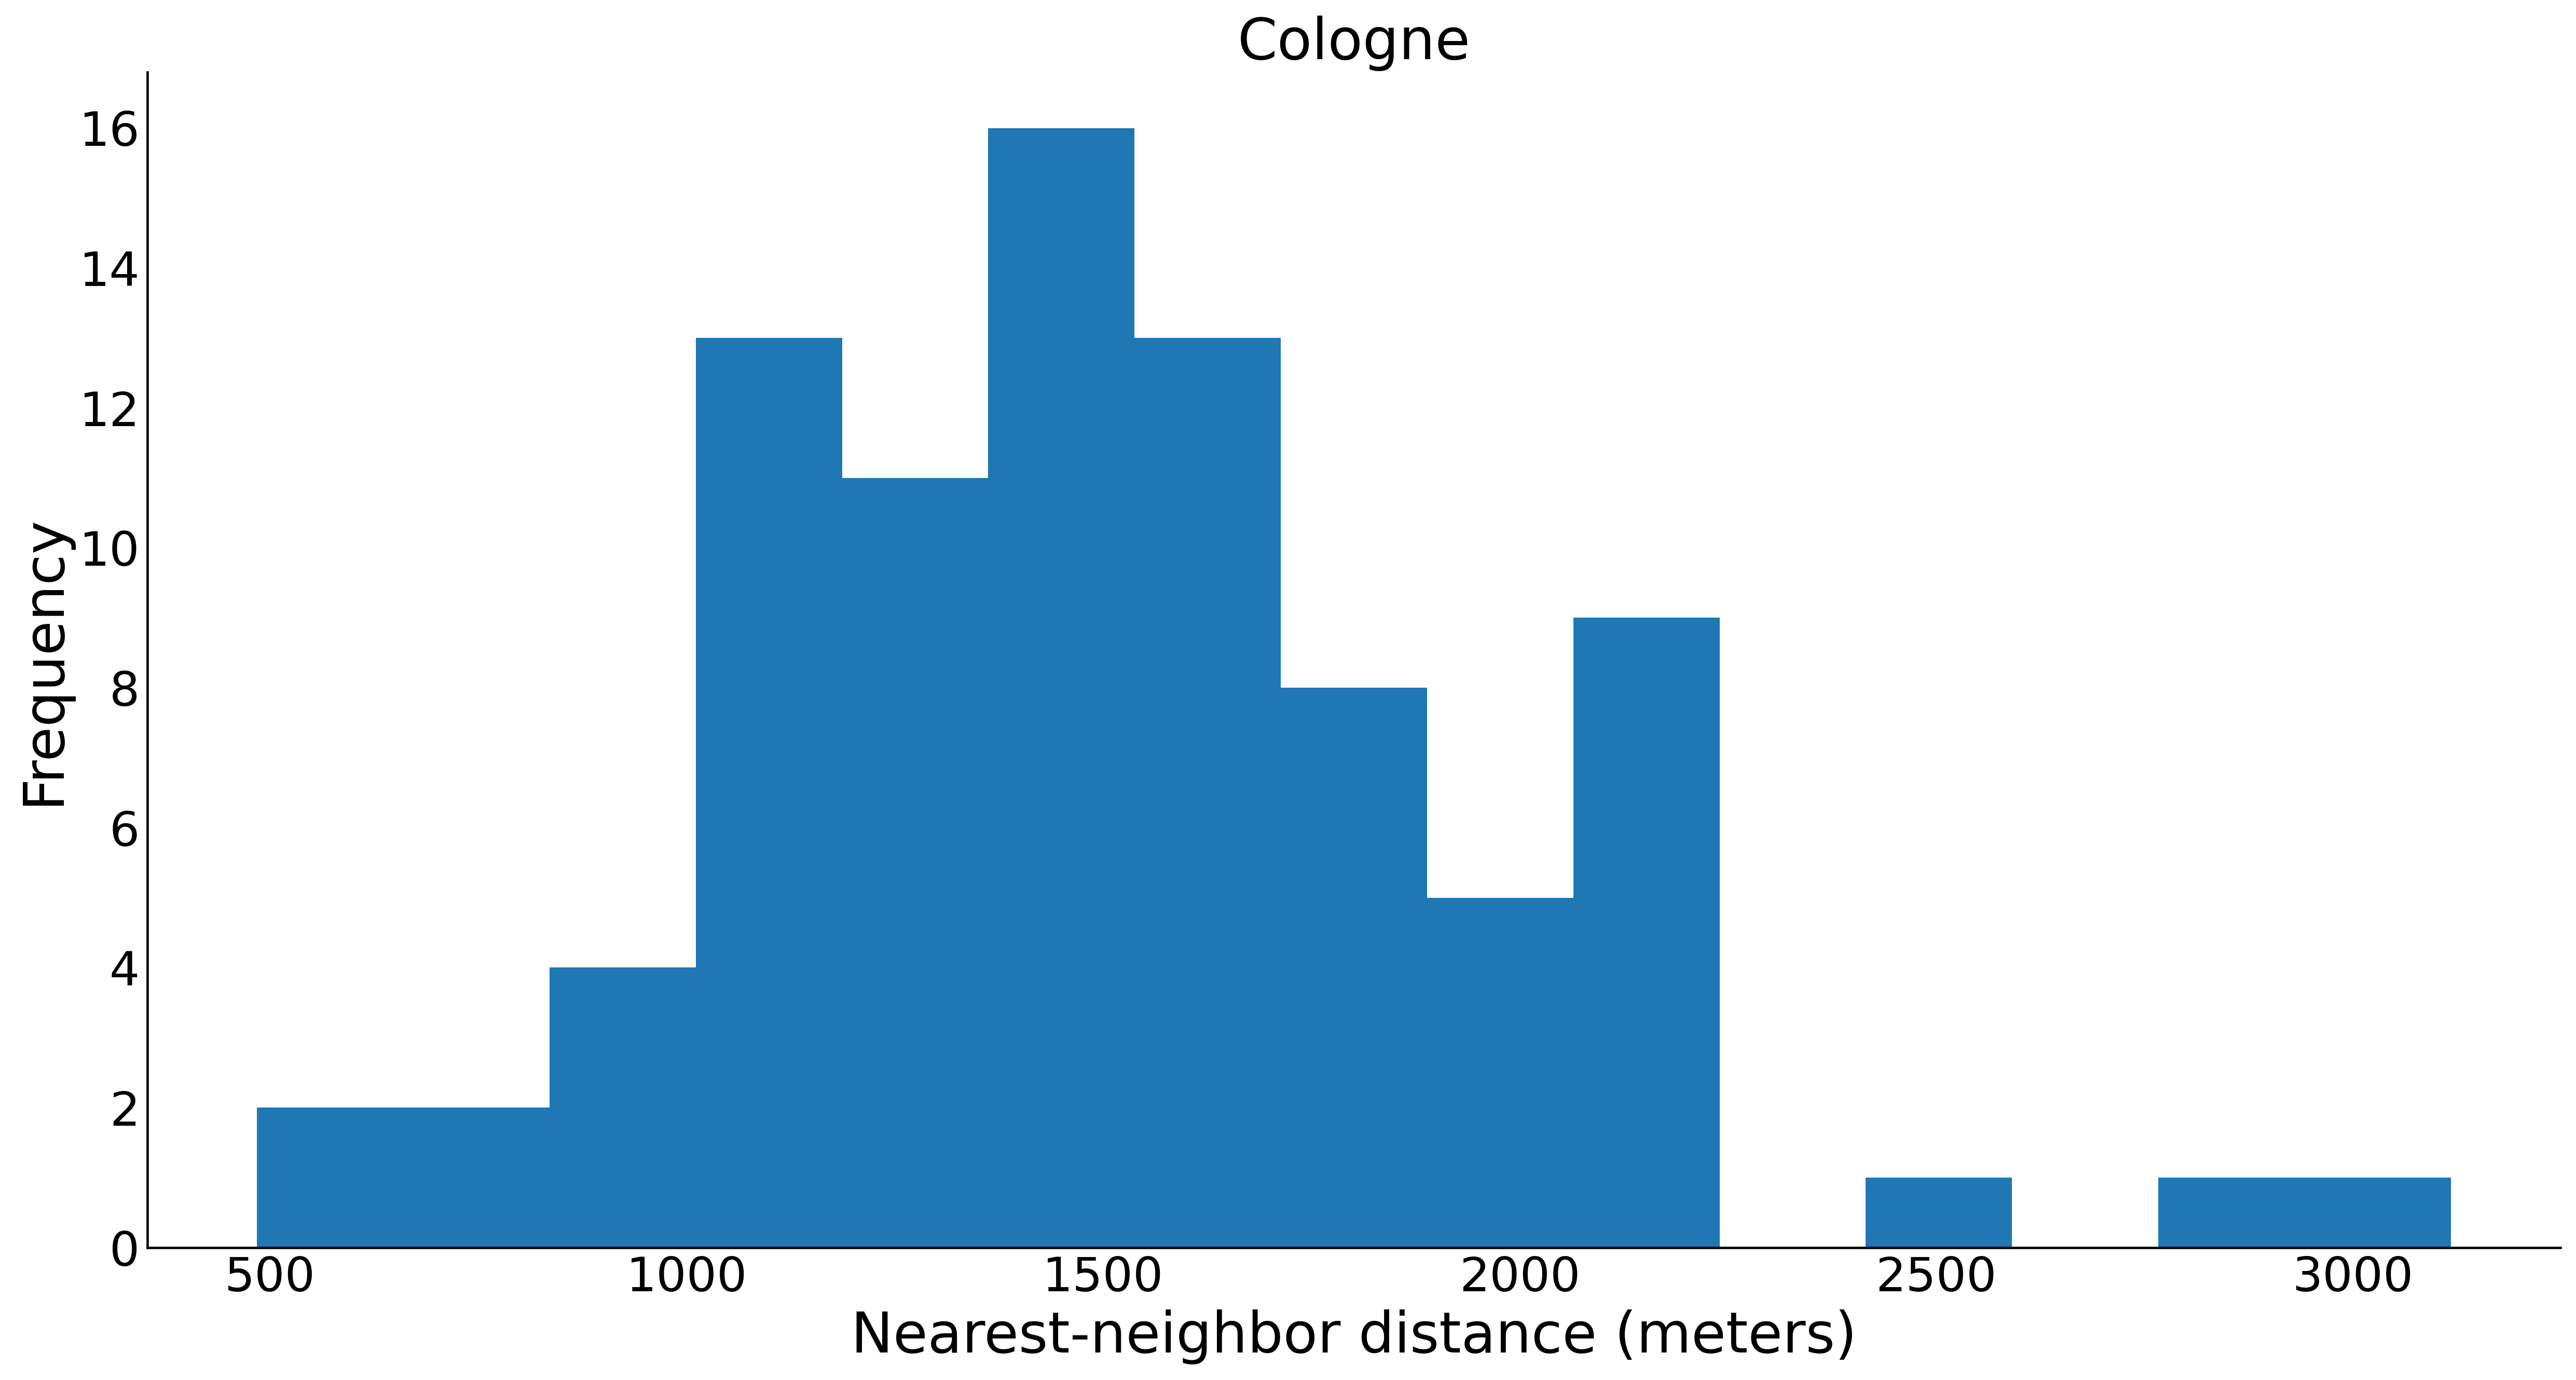

In [17]:
#  [Cologne] distribution of nearest-neighbor distances
ax = co_suburbs_pairs.plot(kind='hist', y='distance', bins=15)
ax.set_xlabel('Nearest-neighbor distance (meters)', fontsize=26)
ax.set_ylabel('Frequency', fontsize=26)
ax.set_title('Cologne')
ax.legend_=None
plt.savefig('images/Cologne_histogram_distances.png')
plt.show()

The percentiles of these distances are also shown below.

In [18]:
#  Berlin
be_suburbs_pairs.distance.describe(percentiles=np.arange(0.1, 1.1, 0.1))

count      96.000000
mean     2259.530047
std       787.798062
min       945.660057
10%      1407.288479
20%      1687.888727
30%      1797.392994
40%      1941.390459
50%      2138.491087
60%      2274.367075
70%      2562.225124
80%      2777.636039
90%      3226.610400
100%     4810.596968
max      4810.596968
Name: distance, dtype: float64

In [19]:
#  Cologne
co_suburbs_pairs.distance.describe(percentiles=np.arange(0.1, 1.1, 0.1))

count      86.000000
mean     1531.804625
std       466.633173
min       484.089643
10%      1070.698023
20%      1165.807548
30%      1281.537289
40%      1427.104020
50%      1479.759705
60%      1592.207529
70%      1683.464820
80%      1865.911057
90%      2115.557197
100%     3117.641094
max      3117.641094
Name: distance, dtype: float64

I wanted the **Foursquare** queries to blend suburb boundaries. Therefore, it made sense to **ask for radii in the range of 10% of the corresponding nearest-neighbor distances**. 

In [20]:
#  Foursquare query radii
Berlin_radius = 1400
Cologne_radius = 1000

##  Identification of the venues of interest for each suburb

In [22]:
#  prepare to talk to the Foursquare API
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
VERSION = '20200101'

Food, shops and services queries were done separately. I consulted the general categories provided by [Foursquare](https://developer.foursquare.com/docs/build-with-foursquare/categories/) and decided to use the following broad categories:

| category | categoryId |
| :--: | :--: |
| food | 4d4b7105d754a06374d81259 |
| shop & service | 4d4b7105d754a06378d81259 |

In [23]:
#  helper function for queries by categoryId
def getVenuesByCatId(names, latitudes, longitudes, radius=500, limit=100, categoryid='4d4b7105d754a06374d81259'):
    import requests
    from time import sleep
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        sleep(1)  #  be polite to the API
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, categoryid, radius, limit)       
        try:
            raw = requests.get(url).json()
            results = raw["response"]['groups'][0]['items']
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])         
        except:
            venues_list.append([(
            name, 
            lat, 
            lng, 
            None, 
            None, 
            None,  
            None)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['suburb', 
                  'lat', 
                  'lon', 
                  'venue', 
                  'venue_lat', 
                  'venue_lon', 
                  'venue_cat']
    
    return nearby_venues, raw


#  check with folium if results make sense
def checkMap(lat, lon, venues):
    fmap = folium.Map(location=[lat, lon], zoom_start=14)
    for la, lo, label in zip(venues['venue_lat'], venues['venue_lon'], venues['venue']):
        pop_label = folium.Popup(label, parse_html=True)
        folium.CircleMarker([la, lo], radius=5, popup=pop_label, color='blue', fill=True, fill_color='#3186cc',
        fill_opacity=0.7, parse_html=False).add_to(fmap)
    folium.CircleMarker([lat, lon], radius=5, popup='Center Point', color='red', fill=True, 
        fill_color='red').add_to(fmap)

    return fmap

### Checking queries for a Berlin and Cologne suburb

In [238]:
#  Berlin
pick = np.random.randint(be_suburbs.shape[0])
food, _ = getVenuesByCatId(be_suburbs.suburb[[pick]], be_suburbs.lat[[pick]], be_suburbs.lon[[pick]], 
                             radius=Berlin_radius, categoryid='4d4b7105d754a06374d81259')
shop, _ = getVenuesByCatId(be_suburbs.suburb[[pick]], be_suburbs.lat[[pick]], be_suburbs.lon[[pick]], 
                             radius=Berlin_radius, categoryid='4d4b7105d754a06378d81259')
check = pd.concat([food, shop], axis=0)
fmap = checkMap(be_suburbs.lat[pick], be_suburbs.lon[pick], check)
fmap

Johannisthal
Johannisthal


In [239]:
#  Cologne
pick = np.random.randint(co_suburbs.shape[0])
food, _ = getVenuesByCatId(co_suburbs.suburb[[pick]], co_suburbs.lat[[pick]], co_suburbs.lon[[pick]], 
                             radius=Cologne_radius, categoryid='4d4b7105d754a06374d81259')
shop, _ = getVenuesByCatId(co_suburbs.suburb[[pick]], co_suburbs.lat[[pick]], co_suburbs.lon[[pick]], 
                             radius=Cologne_radius, categoryid='4d4b7105d754a06378d81259')
check = pd.concat([food, shop], axis=0)
fmap = checkMap(co_suburbs.lat[pick], co_suburbs.lon[pick], check)
fmap

Sürth
Sürth


Great! It seems querying the API worked! 

###  Collecting the venues

In [69]:
#  [Berlin] query for the venues of each suburb and save the collected results or load them up
try:
    be_suburbs_venues = pd.read_hdf('be_suburbs_venues.h5', key='be_suburbs_venues')
except:
    food, _ = getVenuesByCatId(be_suburbs.suburb, be_suburbs.lat, be_suburbs.lon, 
                  radius=Berlin_radius, categoryid='4d4b7105d754a06374d81259')
    shop, _ = getVenuesByCatId(be_suburbs.suburb, be_suburbs.lat, be_suburbs.lon, 
                  radius=Berlin_radius, categoryid='4d4b7105d754a06378d81259')
    be_suburbs_venues = pd.concat([food, shop], axis=0)
    be_suburbs_venues.to_hdf('be_suburbs_venues.h5', key='be_suburbs_venues', mode='w')

In [70]:
#  [Cologne] query for the venues of each suburb and save the collected results or load them up
try:
    co_suburbs_venues = pd.read_hdf('co_suburbs_venues.h5', key='co_suburbs_venues')
except:
    food, _ = getVenuesByCatId(co_suburbs.suburb, co_suburbs.lat, co_suburbs.lon, 
                  radius=Cologne_radius, categoryid='4d4b7105d754a06374d81259')
    shop, _ = getVenuesByCatId(co_suburbs.suburb, co_suburbs.lat, co_suburbs.lon, 
                  radius=Cologne_radius, categoryid='4d4b7105d754a06378d81259')
    co_suburbs_venues = pd.concat([food, shop], axis=0)
    co_suburbs_venues.to_hdf('co_suburbs_venues.h5', key='co_suburbs_venues', mode='w')

I kept all venues that were commonly found in Berlin and Cologne.

In [71]:
common = set(be_suburbs_venues.venue_cat.tolist()).intersection(set(co_suburbs_venues.venue_cat.tolist()))
print(f'Number of common venues across the cities = {len(common)}')

#  keep only common venues across the cities
be_suburbs_venues = be_suburbs_venues[ be_suburbs_venues.venue_cat.isin(common) ]
co_suburbs_venues = co_suburbs_venues[ co_suburbs_venues.venue_cat.isin(common) ]

Number of common venues across the cities = 173


###  Removing outlier suburbs

Then I wanted to see the distribution of venue counts across suburbs so that I could decide which suburbs to keep in the analysis. Suburbs with very few venues reported were not useful to keep. For sure my friends were not interested in such outlier suburbs.

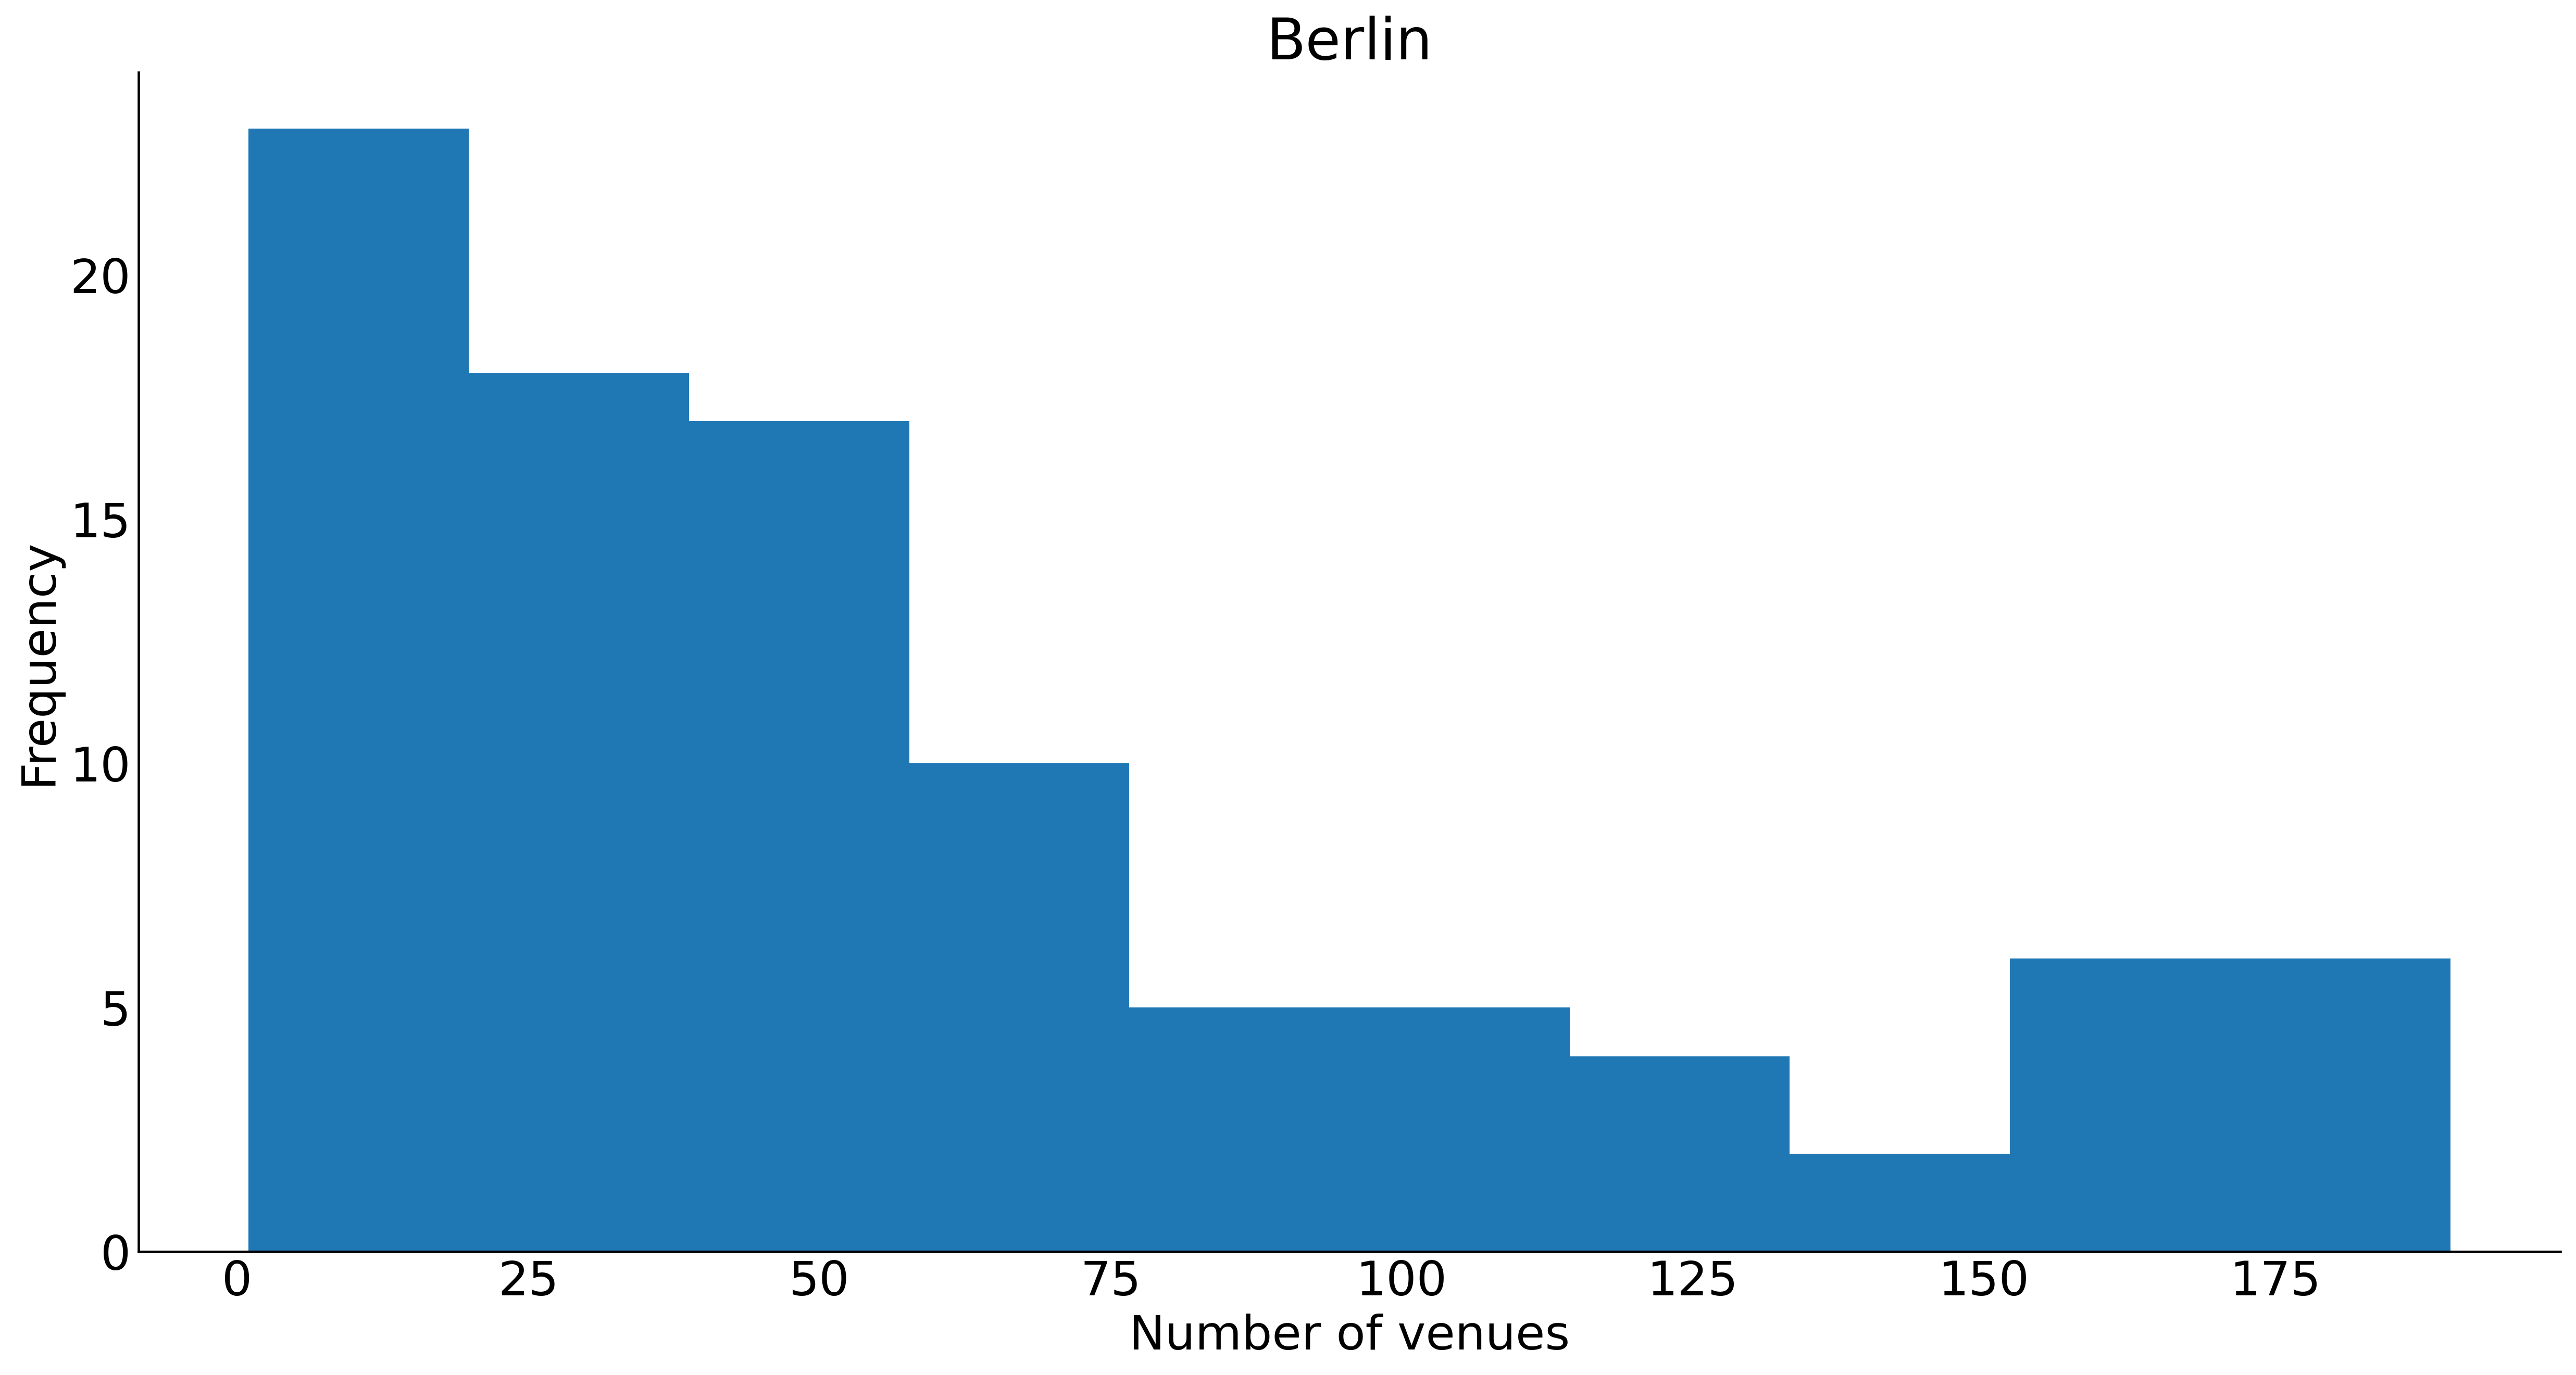

In [72]:
#  [Berlin] distribution of the number of venues per suburb
ax = be_suburbs_venues.groupby('suburb').size().plot(kind='hist')
plt.xlabel('Number of venues')
plt.title('Berlin')
plt.savefig('images/Berlin_histogram_number_of_venues.png')
plt.show()

In [73]:
be_suburbs_venues.groupby('suburb').size().describe()

count     96.000000
mean      62.843750
std       54.298072
min        1.000000
25%       21.750000
50%       46.500000
75%       88.250000
max      190.000000
dtype: float64

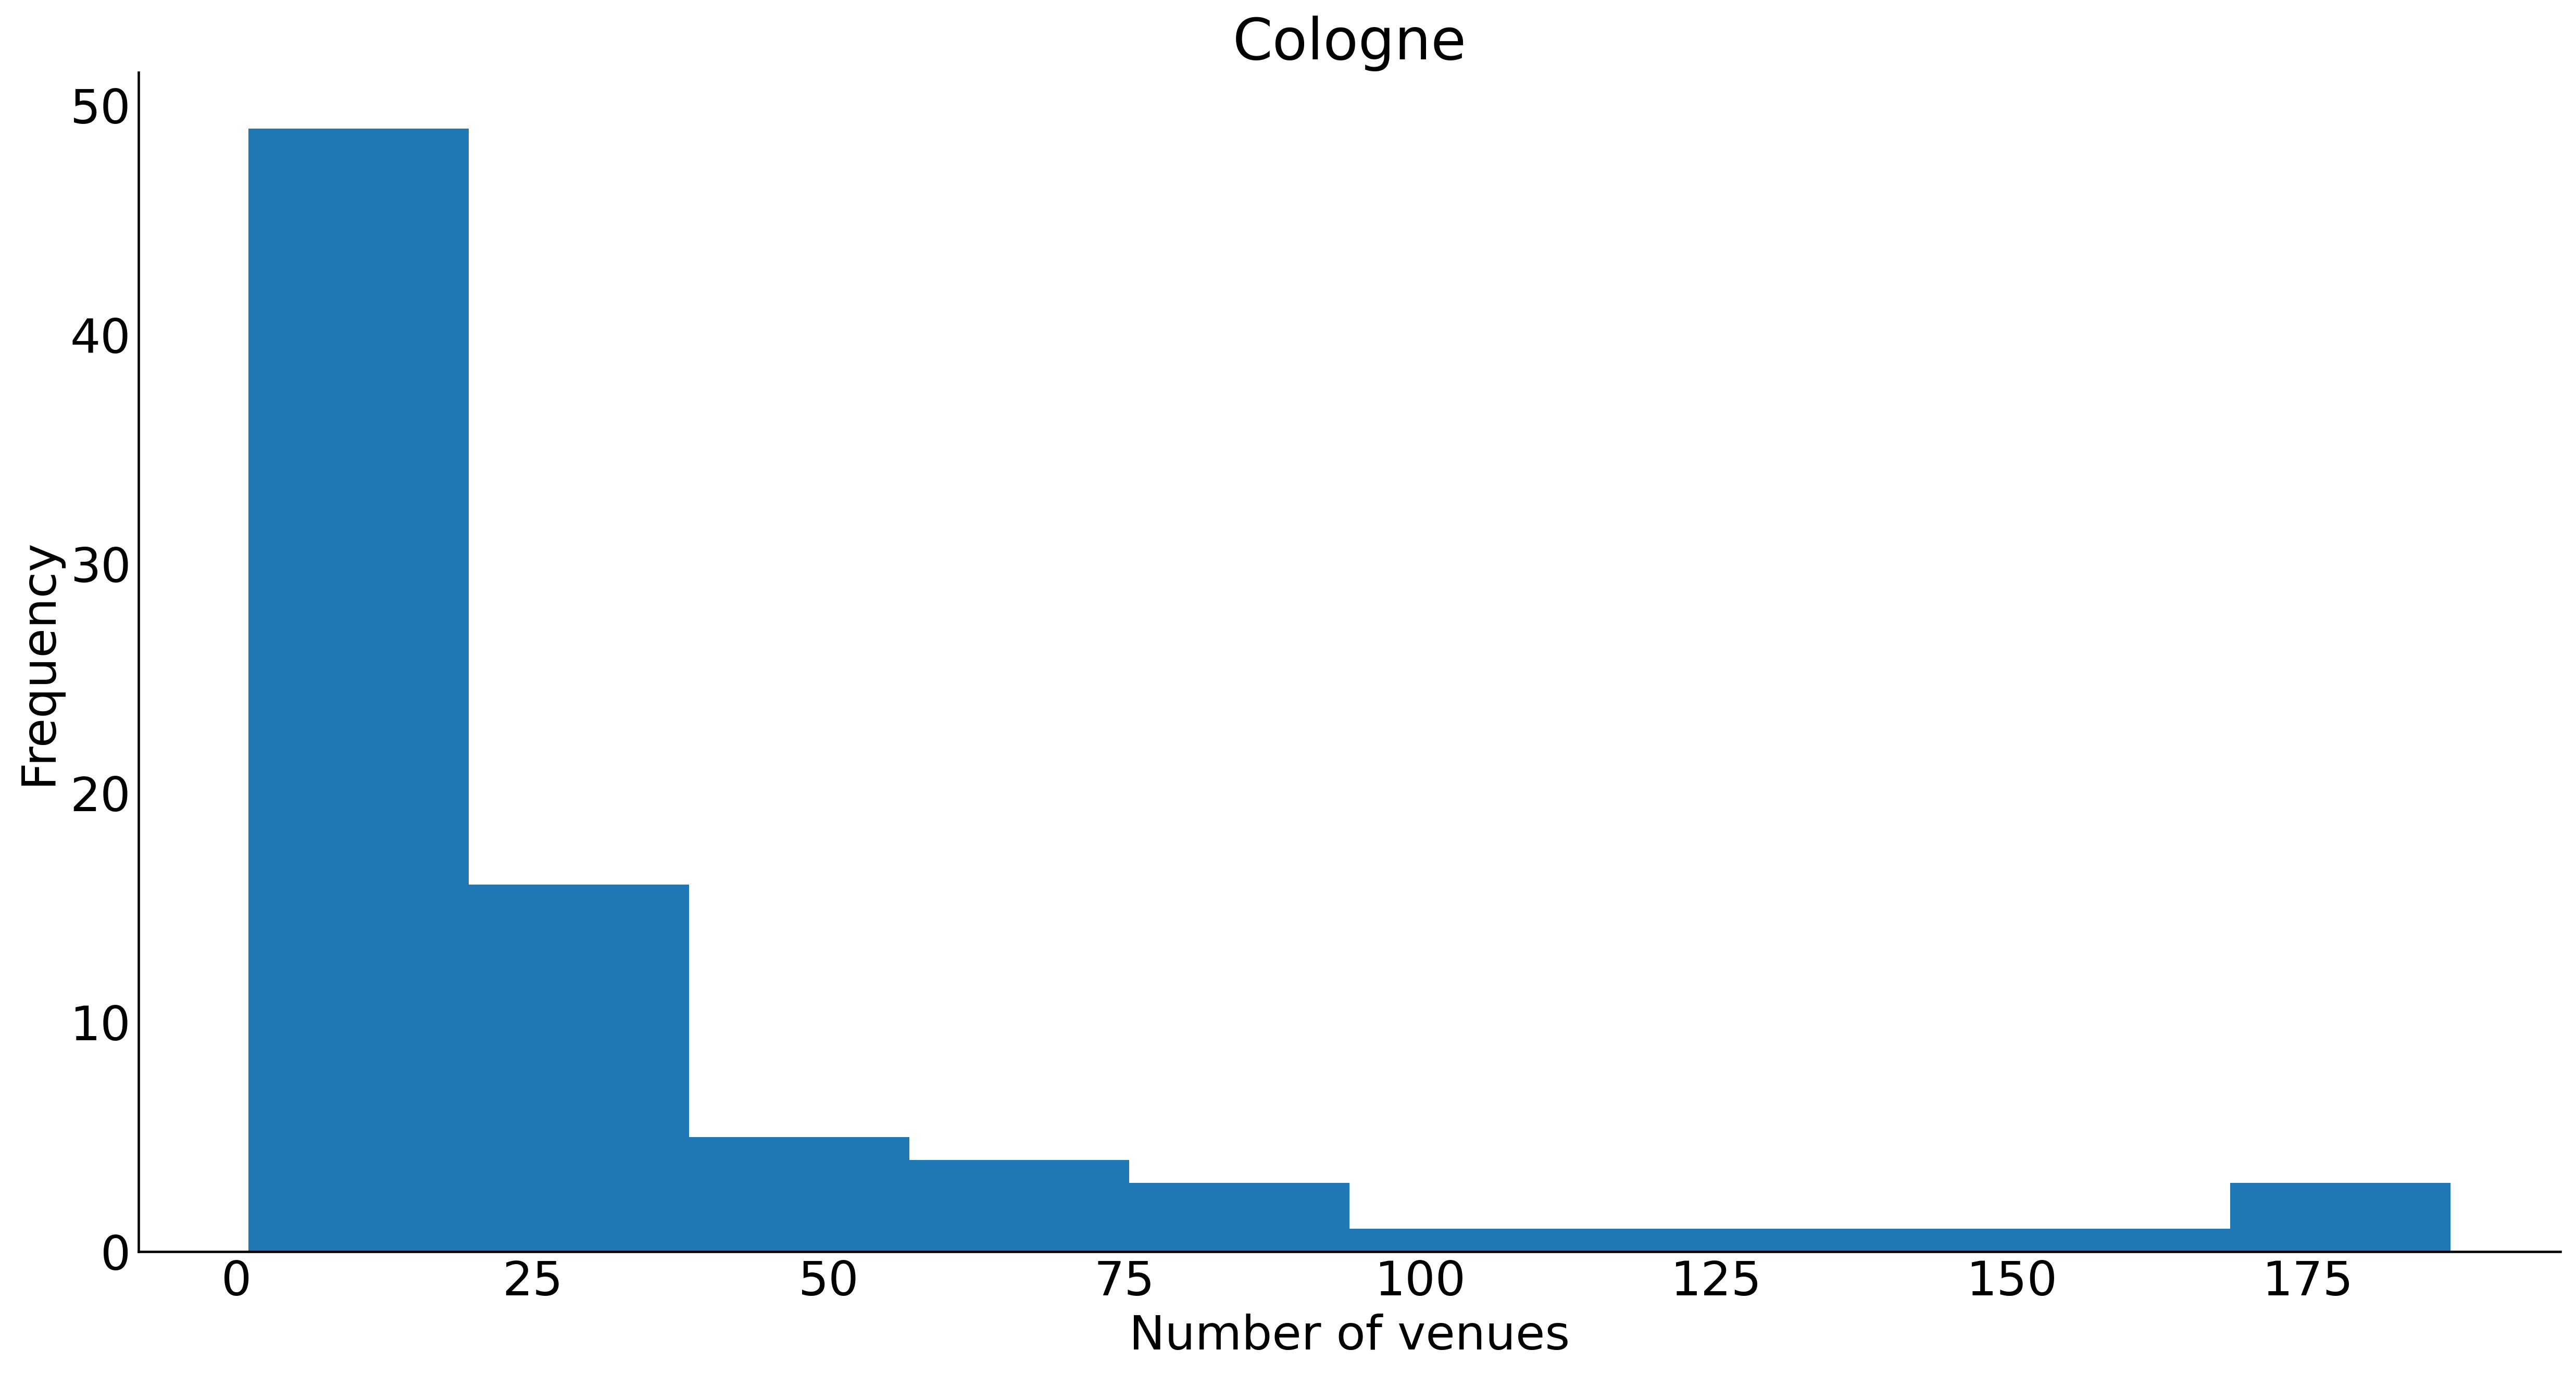

In [74]:
#  [Cologne] distribution of the number of venues per suburb
ax = co_suburbs_venues.groupby('suburb').size().plot(kind='hist')
plt.xlabel('Number of venues')
plt.title('Cologne')
plt.savefig('images/Cologne_histogram_number_of_venues.png')
plt.show()

In [75]:
co_suburbs_venues.groupby('suburb').size().describe()

count     84.000000
mean      32.976190
std       41.669375
min        1.000000
25%       10.000000
50%       17.000000
75%       32.500000
max      187.000000
dtype: float64

I decided to keep only three quarters of suburbs from each city by removing 25% belonging to the lower range of venue counts. 

In [76]:
#  minimum number of venues per suburb, all suburbs below this will be filtered out
Berlin_venues = be_suburbs_venues.groupby('suburb').size().quantile(0.25)
Cologne_venues = co_suburbs_venues.groupby('suburb').size().quantile(0.25)
Berlin_venues, Cologne_venues

(21.75, 10.0)

In [77]:
#  [Berlin] filter out outlier suburbs
g = be_suburbs_venues.groupby('suburb').size()
be_suburbs_venues = be_suburbs_venues[ be_suburbs_venues.suburb.isin(g.index[ g>=Berlin_venues ].tolist()) ].reset_index(drop=True)

#  [Cologne] filter out outlier suburbs
g = co_suburbs_venues.groupby('suburb').size()
co_suburbs_venues = co_suburbs_venues[ co_suburbs_venues.suburb.isin(g.index[ g>=Cologne_venues ].tolist()) ].reset_index(drop=True)

print(f'Number of Berlin suburbs we will use in the analysis = {len(be_suburbs_venues.suburb.unique())}')
print(f'Number of Cologne suburbs we will use in the analysis = {len(co_suburbs_venues.suburb.unique())}')

Number of Berlin suburbs we will use in the analysis = 72
Number of Cologne suburbs we will use in the analysis = 65


###  Remove outlier venues

I filtered suburbs based on common venue counts which naturally altered the set of common venues. So I recomputed this set and removed again venues that were no longer common.

In [78]:
common = set(be_suburbs_venues.venue_cat.tolist()).intersection(set(co_suburbs_venues.venue_cat.tolist()))
print(f'Number of common venues across the cities = {len(common)}')

#  keep only common venues across the cities
be_suburbs_venues = be_suburbs_venues[ be_suburbs_venues.venue_cat.isin(common) ]
co_suburbs_venues = co_suburbs_venues[ co_suburbs_venues.venue_cat.isin(common) ]

Number of common venues across the cities = 171


Different venues had largely different frequencies of occurrence across the suburbs. For example Supermarkets were the most frequent with many instances even within the same suburb, whereas certain types of restaurants, from example a Mongolian restaurant, were the least frequent. Since I made sure that only common venues were kept at this point of the analysis, I decided to add all venue counts across the two cities and remove again venues that were in the lower 25% range of counts.

In [79]:
#  frequency of venues across the city suburbs
be_freq = be_suburbs_venues.venue_cat.value_counts()
co_freq = co_suburbs_venues.venue_cat.value_counts()

#  add frequencies together (powerful pandas feature: it aligns the indices and does the addition)
freq = be_freq + co_freq
venues_to_keep = freq[ freq >= freq.quantile(0.25) ].index.values.tolist()
print(f'Final number of venues kept in the analysis = {len(venues_to_keep)}')

#  filter the venues from the data sets
be_suburbs_venues = be_suburbs_venues[ be_suburbs_venues.venue_cat.isin(venues_to_keep) ]
co_suburbs_venues = co_suburbs_venues[ co_suburbs_venues.venue_cat.isin(venues_to_keep) ]

Final number of venues kept in the analysis = 135


## Methodology

Our goal was to make of map of Cologne suburbs to Berlin suburbs by minimizing their dissimilarity based on their number and type of venues. I quantified suburb dissimilarity by the **normalized Euclidean distance in feature space**. The normalization was just the number of features entering the analysis in order to make the dissimilarity measure invariant to changes in this number.

In order to make it easy for my friends, I reported the top two similar suburbs of Berlin for each of the suburbs of Cologne. Also, for each pair I reported the top similar and top dissimilar features these two suburbs had.

###  Preparation of the feature space

In [80]:
#  [Berlin] one-hot encode venues
#           sum by suburb
#           normalize across suburbs
be_features = pd.get_dummies(be_suburbs_venues[['venue_cat']], prefix='', prefix_sep='', dtype=np.int32)
be_features = pd.concat([be_suburbs_venues[['suburb']], be_features], axis=1)
be_features = be_features.groupby('suburb').sum()
be_features = (be_features - be_features.mean(axis=0))/be_features.std(axis=0)

#  [Cologne] one-hot encode venues
#            sum by suburb
#            normalize across suburbs
co_features = pd.get_dummies(co_suburbs_venues[['venue_cat']], prefix='', prefix_sep='', dtype=np.int32)
co_features = pd.concat([co_suburbs_venues[['suburb']], co_features], axis=1)
co_features = co_features.groupby('suburb').sum()
co_features = (co_features - co_features.mean(axis=0))/co_features.std(axis=0)

#  make sure column order is identical
assert( np.all(co_features.columns == be_features.columns) )

#  pandas are in the way for matrix calculations, let's convert to arrays
co = co_features.values
be = be_features.values

### Finding the two most similar suburbs

I wanted to minimize the dissimilarity between suburbs, captured by the normalized Euclidean distance in feature space which is invariant to the number of features entering the analysis. The range of the dissimilarity metric can vary. Values **very close to zero** indicate **strongly similar suburbs**. Values in the range **[0.1, 0.2]** indicate **somewhat similar suburbs** and the rest indicate **strongly dissimilar suburbs**. 

In [81]:
def ClosestFurthestFeatures(a, N):
    cl = a.argsort()
    fu = cl[-N:][::-1]  #  reverse order to have most distant first
    cl = cl[:N]
    
    #  return top similar, top dissimilar as an array
    #  N.B. np.array() bug truncates strings to 64 characters, when converted to object they are left alone
    return np.array([', '.join(be_features.columns[cl]), ', '.join(be_features.columns[fu])], dtype=np.object_)

Nsuburbs = 2   #  number of most similar suburbs to report
Nfeatures = 6  #  number of most similar/dissimilar features to report
final = pd.DataFrame(columns=['Cologne suburb', 'Berlin suburb', 'dissimilarity', 'top similar features', 
                              'top dissimilar features'])
for n in range(co.shape[0]):
    diff = be - co[n,:]
    dissimilarity = np.linalg.norm(diff, axis=1)/diff.shape[1]  #  normalize by the number of features
    iClosest = dissimilarity.argsort()[:Nsuburbs]

    #  top similar and dissimilar features
    cl_fu_features = np.apply_along_axis(ClosestFurthestFeatures, 1, diff[iClosest, :], N=Nfeatures)

    #  build the DataFrame
    df = pd.concat([ pd.Series(co_features.index.values[ [n] * Nsuburbs ]),  #  Cologne suburb
                     pd.Series(be_features.index.values[iClosest]),          #  most similar Berlin suburbs
                     pd.Series(dissimilarity[iClosest]),                     #  dissimilarity
                     pd.DataFrame(cl_fu_features)                            #  top similar/dissimilar features
                   ], axis=1)
    df.columns = final.columns
    final = pd.concat([final, df], axis=0, ignore_index=True)

#  use Cologne and Berlin suburbs as indices
final = final.set_index(['Cologne suburb', 'Berlin suburb'])

## Results

In [82]:
#  Behold the map of Cologne to Berlin suburbs
pd.set_option('display.max_rows', None)
final

dissimilarity  \
Cologne suburb       Berlin suburb                         
Altstadt-Nord        Steglitz                   0.173420   
                     Tiergarten                 0.185759   
Altstadt-Süd         Charlottenburg             0.153988   
                     Steglitz                   0.167122   
Bayenthal            Heinersdorf                0.108275   
                     Waidmannslust              0.108364   
Bickendorf           Weißensee                  0.090279   
                     Britz                      0.098458   
Bilderstöckchen      Biesdorf                   0.048144   
                     Dahlem                     0.052537   
Bocklemünd/Mengenich Dahlem                     0.060193   
                     Bohnsdorf                  0.060864   
Braunsfeld           Kaulsdorf                  0.100739   
                     Marienfelde                0.105325   
Brück                Biesdorf                   0.041889   
                     Friedrichshagen            0.045860   
Buchforst            Lichtenrade                0.097590   
                     Hermsdorf                  0.098277   
Buchheim             Biesdorf                   0.055712   
                     Hermsdorf                  0.056919   
Chorweiler           Marzahn                    0.067567   
                     Buckow                     0.070244   
Dellbrück            Waidmannslust              0.057571   
                     Hermsdorf                  0.059366   
Deutz                Charlottenburg-Nord        0.146693   
                     Siemensstadt               0.146733   
Dünnwald             Köpenick                   0.040688   
                     Lichtenrade                0.050522   
Ehrenfeld            Schöneberg                 0.176305   
                     Neukölln                   0.176896   
Ensen                Hermsdorf                  0.065884   
                     Biesdorf                   0.066434   
Finkenberg           Britz                      0.065294   
                     Biesdorf                   0.067811   
Fühlingen            Biesdorf                   0.043208   
                     Hermsdorf                  0.045928   
Gremberghoven        Biesdorf                   0.062076   
                     Hermsdorf                  0.062517   
Hahnwald             Kaulsdorf                  0.063839   
                     Biesdorf                   0.064648   
Heimersdorf          Dahlem                     0.051657   
                     Lankwitz                   0.064615   
Holweide             Hermsdorf                  0.057801   
                     Biesdorf                   0.057874   
Humboldt/Gremberg    Mahlsdorf                  0.070167   
                     Rosenthal                  0.074589   
Höhenberg            Biesdorf                   0.049129   
                     Kaulsdorf                  0.057311   
Höhenhaus            Biesdorf                   0.042695   
                     Kaulsdorf                  0.047671   
Junkersdorf          Biesdorf                   0.090196   
                     Staaken                    0.091097   
Kalk                 Buckow                     0.150866   
                     Neu-Hohenschönhausen       0.160234   
Klettenberg          Marienfelde                0.053108   
                     Kaulsdorf                  0.054405   
Lind                 Biesdorf                   0.039974   
                     Kaulsdorf                  0.046497   
Lindenthal           Friedrichshagen            0.105620   
                     Dahlem                     0.107012   
Lindweiler           Dahlem                     0.045880   
                     Friedrichshagen            0.048092   
Lövenich             Biesdorf                   0.045839   
                     Köpenick                   0.045948   
Marienburg           Biesdorf                   0.046008   
                     Da

I show below the distribution of Cologne suburb dissimilarities to their corresponding best choice of Berlin suburb. On the one hand, there were Cologne suburbs very close in *character* to the Berlin ones. On the other hand, there were also suburbs which seemed to be unique in their Cologne *character* and their closest counterpart in Berlin was quite dissimilar.

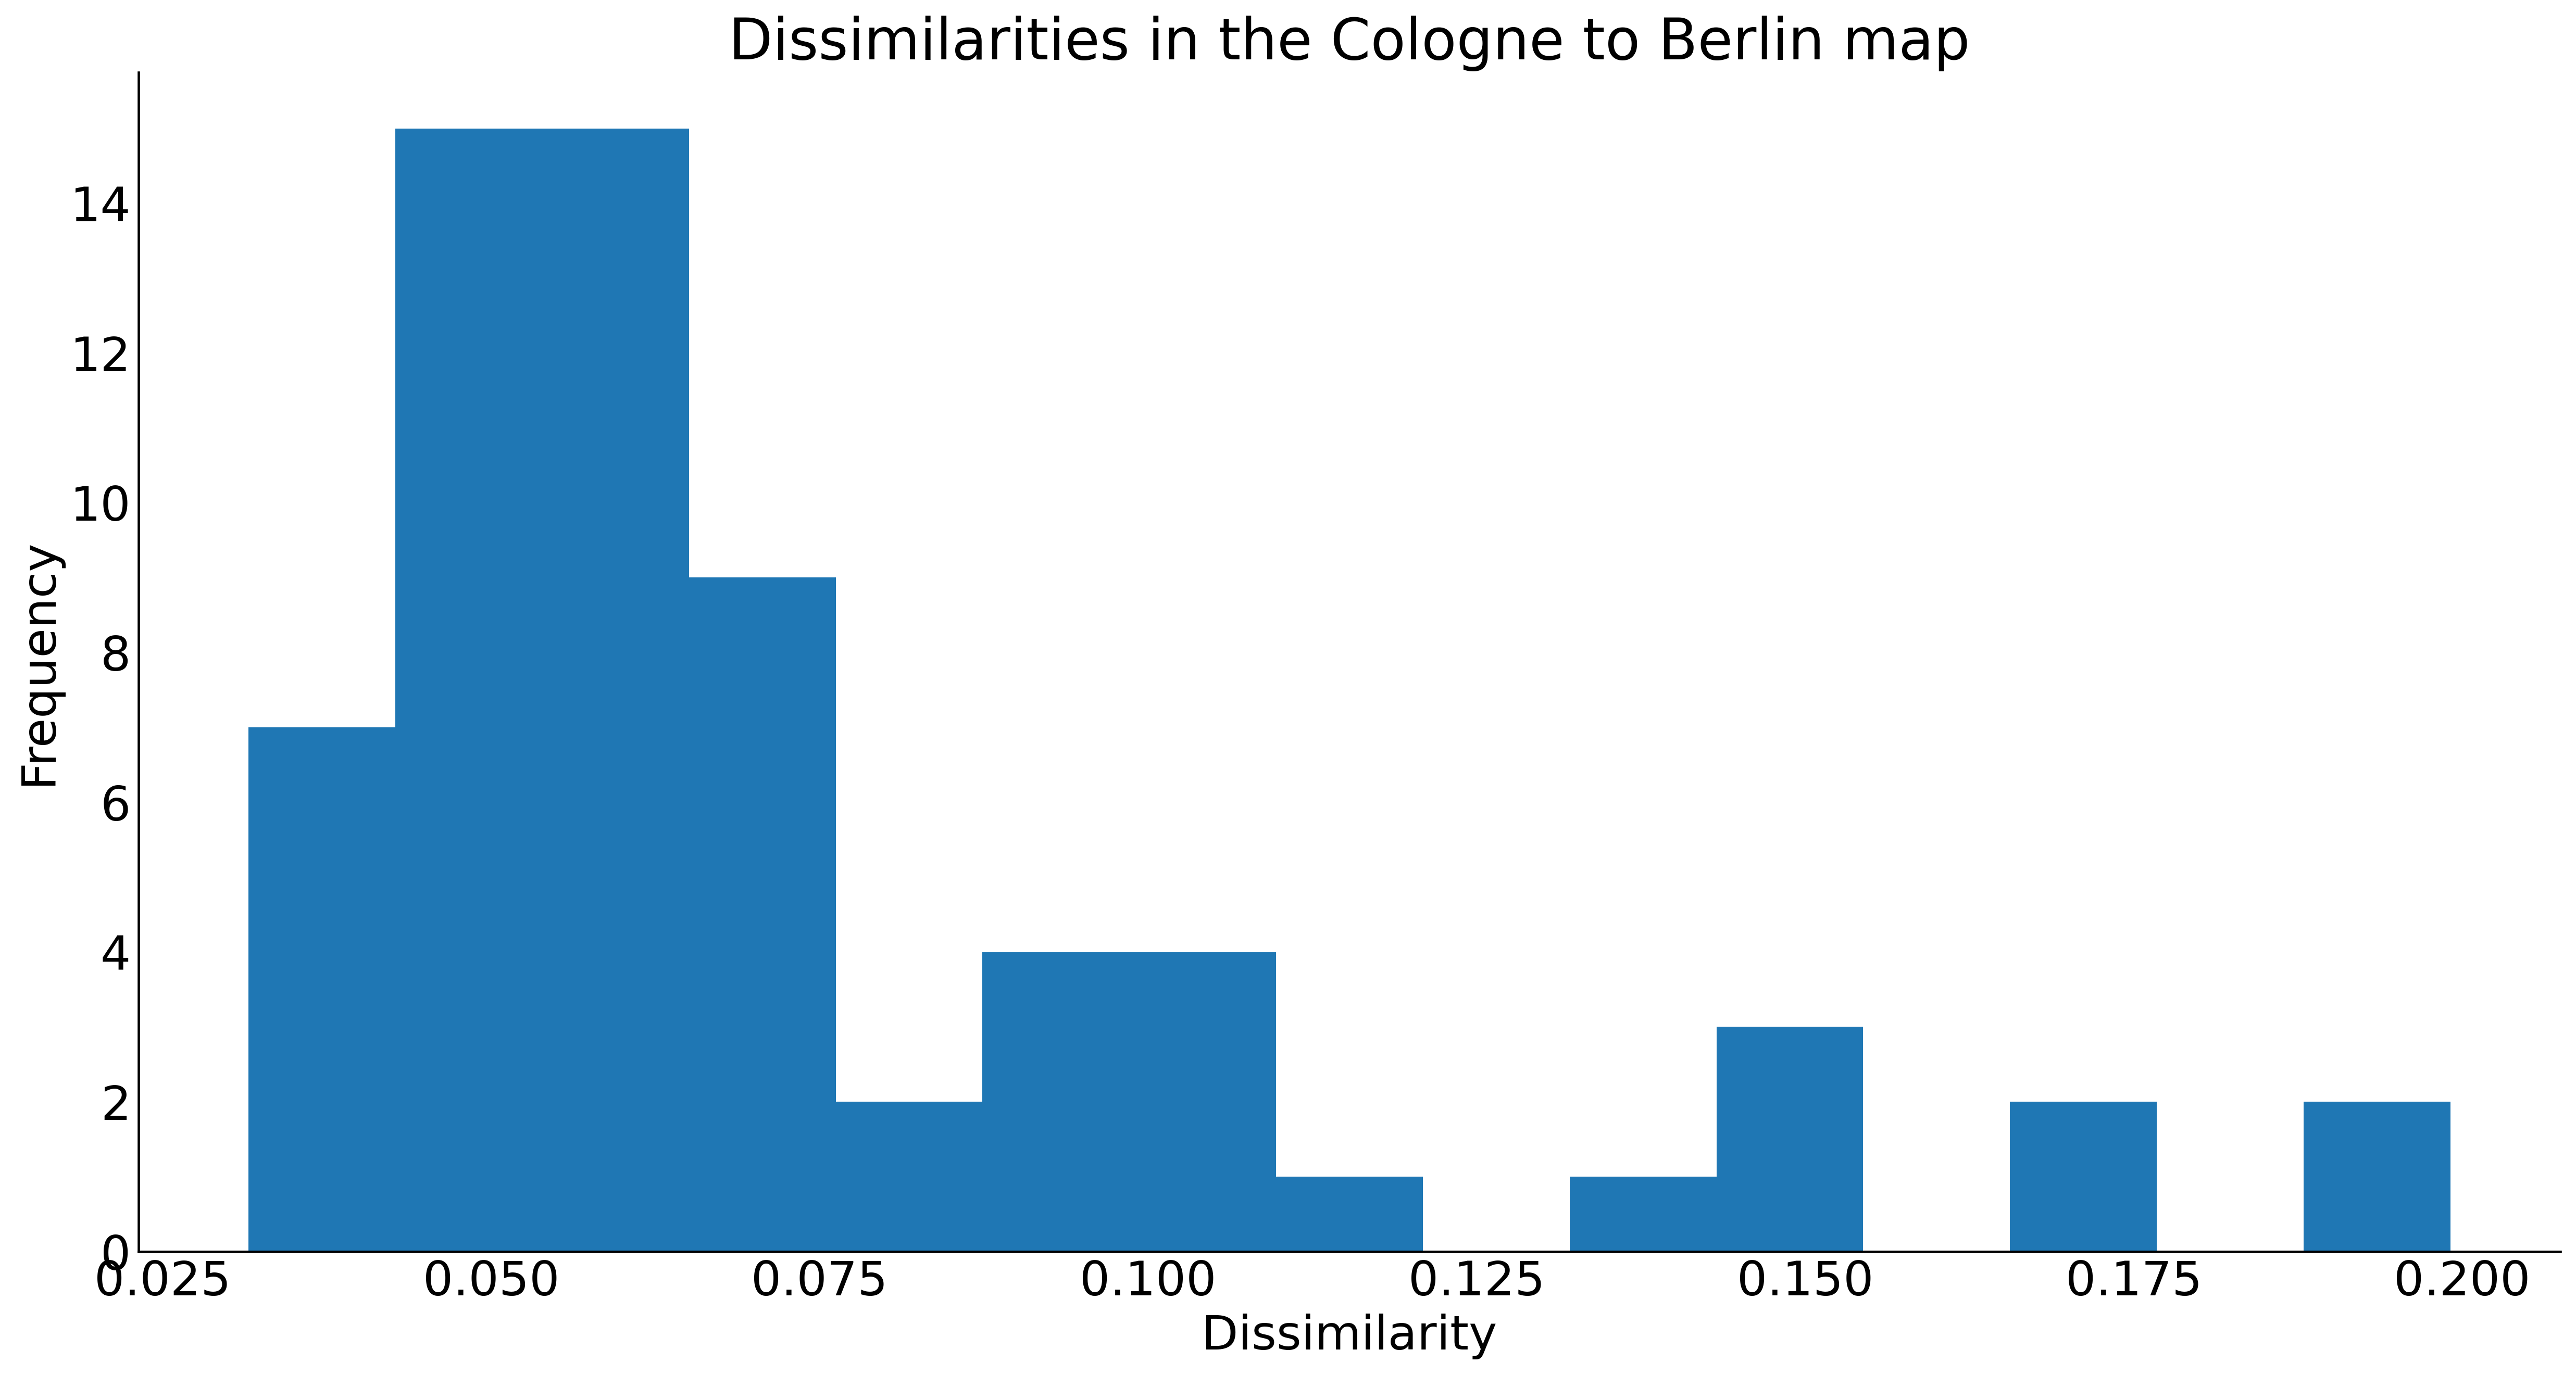

In [84]:
ax = final.groupby(level=0).nth(0).dissimilarity.plot(kind='hist', bins=15)
plt.xlabel('Dissimilarity')
plt.title('Dissimilarities in the Cologne to Berlin map')
plt.savefig('images/Final_histogram_distance.png')
plt.show()

In [85]:
#  statistics of dissimilarities of the best suburb choices
final.groupby(level=0).nth(0).dissimilarity.describe(percentiles=np.arange(0.1, 1.1, 0.1))

count    65.000000
mean      0.075886
std       0.039843
min       0.031552
10%       0.042901
20%       0.046654
30%       0.051764
40%       0.057247
50%       0.062260
60%       0.066557
70%       0.074891
80%       0.098219
90%       0.144409
100%      0.199085
max       0.199085
Name: dissimilarity, dtype: float64

## Discussion

I found the Cologne to Berlin suburb map very interesting. It turned out, the Cologne city center suburbs were very distant from all choices in Berlin and vice versa, no Berlin city center suburb was found similar with any of the Cologne suburbs. Citi centers seem to have a unique non-transferable *character*. However, it is clear that a *character* of a suburb cannot be captured only by looking at food venues, shops and services. Nevertheless, this simple first approach to the problem gave my friends some broad-stroke ideas about the Berlin suburbs in order to get them going and help them narrowing down their choices.

On the Data Science side of things, I can see many areas where this analysis could be expanded and improved. Firstly, I will move away from the **Foursquare API** limitations and switch completely to the **Open Street Maps API** where it is possible to query multipolygon areas for anything with no limitations. That way the whole suburb area can be queried for features instead of a fixed radius around a node. Also, there is a wealth of information that one can add to the suburb *character* features that is not even available at **Foursquare**, like number of trees, area of the suburb covered by greenery, public transporation density, etc. Although such an analysis will take me beyond the scope of this project, I still consider it an interesting project to work on in the future.

The question asked by my friends was a very specific one. I was tempted to use machine-learning methods like K-means clustering in order to identify groups of suburbs across the cities. However, such an analysis would not have answered the question that my friends asked. If anything, it would have left them more confused having to choose by themselves among the suburbs that co-clustered with a Cologne suburb. I chose a way of analysis that was tailored to the exact question asked: *Can you make a map of the Cologne to Berlin suburbs for us?*

## Conclusions

A map of the Cologne to Berlin suburbs was made by looking at very basic information like food venues, shops and various services. Suburbs of Cologne were mapped to the two closest suburbs in Berlin, listing also the distance in Euclidean feature space as well as information about the top similar and top dissimilar features involved. The results were quite satisfactory. This analysis can serve as a blueprint for future work that can expand it and improve on the type of features used in order to capture more accurately the *character* of suburbs. 